In [14]:
%matplotlib inline
# initialization:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
# Importing standard Qiskit libraries and configuring account
from qiskit import QuantumCircuit, execute, BasicAer, IBMQ
from qiskit.providers.ibmq import least_busy
from qiskit.compiler import transpile, assemble
from qiskit.tools.jupyter import *
from qiskit.tools.monitor import job_monitor
from qiskit.visualization import *
# Loading your IBM Q account(s)
provider = IBMQ.load_account()

ibmqfactory.load_account:WARNING:2020-06-22 09:07:48,974: Credentials are already in use. The existing account in the session will be replaced.


In [3]:
# Simon's Algorithm:
#           Given an unknown blackbox funnction f,
#           which is quaranteed to be either 1:1 or 2:1.
#           That is to say 
#       either: f is a 1 to 1 maping, 
#                   where for every unique x value maps to a single unique f(x).    
#           or:   f is a 2 to 1 maping,
#                  where exactly 2 unique x vals map to the same f(x).
# Given this blackbox function how quickly can we determine which type of function f is?
# Then is f is 2:1 how quickly can we determine s, where if f is 2:1.
#                                given x1,x2: f(x1) = f(x)
#                                it is guaranteed: x1 CNOT x2 = s

# ========== Classical Solution: ============
# The traditional approach requires us to check up to 2^[N-1] + 1 inputs.
# Where N is the number of bits in the input. 
# Therefore we would have to check on avg. half of all inputs to be 100% positve the function was 2:1.

# ========== Quantum Solution: ==========
# Steps:
#      1. Two n-qubit input registers are initialized to the 0 state:
#             |ψ1> = |0⟩^⊗n |0⟩^⊗n
#      2. Apply a Hadamard transform to the first register:
#             |ψ2⟩ = 1/sqrt(2^n)*∑[x∈{0,1}^n] |x⟩|0⟩⊗n
#      3. Apply the query function Qf:
#             |ψ3⟩=1/sqrt(2^n) * ∑x∈[{0,1}^n] |x⟩|f(x)⟩
#      4. Measure the second register. A certain value of f(x) will be observed.
#         BC of the setting of the problem, the observed value f(x) could
#         correspond to two possible inputs: x & y = x⊕s
#         Therefore the first register becomes:
#             |ψ4⟩ = [1/sqrt(2)]( |x⟩ + |y⟩ )
#      5. Apply Hadamard on the first regisiter:
#             |ψ5⟩ = 1/sqrt(2^[n+1])*∑z∈[{0,1}n] [ (−1)^(x⋅z) + (−1)^(y⋅z) ] | z⟩
#      6. Measuring the first register will give an output only if:
#             (−1)^(x⋅z)=(−1)^(y⋅z)
#           which means:
#                     x*z = y*z
#                     x*z = (x XOR s)*z
#                     x*z = x*(z XOR s)*z
#                     s*z = 0%2
#         A string z whose inner product with s will be measured. Thus, repeating the 
#         algorithm ~~ n times, we will be able to obtain n different values of z & the 
#         following system of equations can be written:
#        
#                      s*z1 = 0
#                      s*z2 = 0
#                      ...
#                      s*zn = 0
#         From which we can find s using Gaussian elimination.

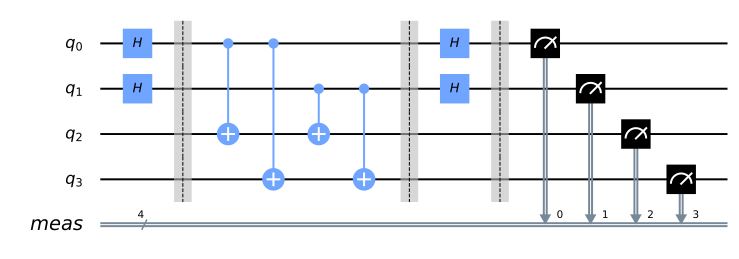

In [8]:
# currently using a fixed string implementation, should expand to a random general case:
# Creating registers
# qubits and classical bits for querying the oracle and finding the hidden period s
n = 2*len(str(s))
simonCircuit = QuantumCircuit(n)
barriers = True

# Apply Hadamard gates before querying the oracle
simonCircuit.h(range(len(str(s))))    
    
# Apply barrier 
if barriers:
    simonCircuit.barrier()

# Apply the query function
## 2-qubit oracle for s = 11
simonCircuit.cx(0, len(str(s)) + 0)
simonCircuit.cx(0, len(str(s)) + 1)
simonCircuit.cx(1, len(str(s)) + 0)
simonCircuit.cx(1, len(str(s)) + 1)  

# Apply barrier 
if barriers:
    simonCircuit.barrier()

# Apply Hadamard gates to the input register
simonCircuit.h(range(len(str(s))))

# Measure ancilla qubits
simonCircuit.measure_all()
simonCircuit.draw(output='mpl')


{'11': 537, '00': 487}


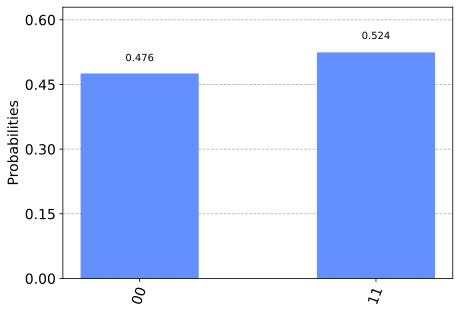

In [10]:
# use local simalator:
backend = BasicAer.get_backend('qasm_simulator')
shots = 1024
results = execute(simonCircuit,backend=backend,shots=shots).result()
answer = results.get_counts()

answer_plot = {}
for measresult in answer.keys():
    measresult_input = measresult[len(str(s)):]
    if measresult_input in answer_plot:
        answer_plot[measresult_input] += answer[measresult]
    else:
        answer_plot[measresult_input] = answer[measresult]

print(answer_plot)
plot_histogram(answer_plot)

In [13]:
# Calculate the dot product of the results
def sdotz(a,b):
    accum = 0
    for i in range(len(a)):
        accum += int(a[i]) * int(b[i])
    return( accum % 2 )
print('a,z,s.z(mod 2)')
for z_rev in answer_plot:
    z = z_rev[::-1]
    print('{},{},{},{}={}'.format(s,z,s,z,sdotz(s,z)))

a,z,s.z(mod 2)
11,11,11,11=0
11,00,11,00=0


In [15]:
# Run our circuit on the least busy backend
shots = 1024
job = execute(simonCircuit,backend=backend,shots=shots)
job_monitor(job,interval=2)

Job Status: job has successfully run


{'11': 537, '00': 487}


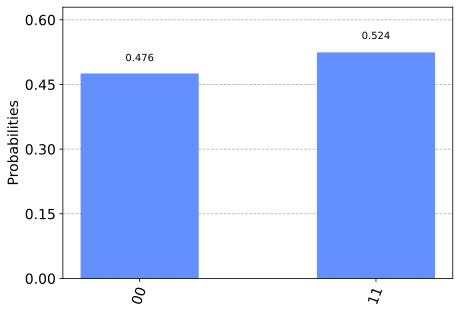

In [16]:
# Categorize measurements by input register values
answer_plot = {}
for measresult in answer.keys():
    measresult_input = measresult[len(str(s)):]
    if measresult_input in answer_plot:
        answer_plot[measresult_input] += answer[measresult]
    else:
        answer_plot[measresult_input] = answer[measresult] 

# Plot the categorized results
print( answer_plot )
plot_histogram(answer_plot)

In [17]:
# Calculate the dot product of the most significant results
print('s, z, s.z (mod 2)')
for z_rev in answer_plot:
    if answer_plot[z_rev] >= 0.1*shots:
        z = z_rev[::-1]
        print( '{}, {}, {}.{}={}'.format(s, z, s,z,sdotz(s,z)) )

s, z, s.z (mod 2)
11, 11, 11.11=0
11, 00, 11.00=0
